In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [14]:
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as mb

In [15]:
opsdb = db.OpsimDatabase('astro-lsst-01_2022.db')

In [16]:
simdata = opsdb.query_columns(opsdb.defaultTable, 
                              colnames=['fieldRA', 'fieldDec', 'filter', 'night', 'observationStartMJD'], 
                              sqlconstraint=None)

In [17]:
# Go do what you like with the data! 
simdata[0:10]

array([( 305.088793, -24.889283, 'z', 1,  59853.01679398),
       ( 302.89208 ,  29.966322, 'z', 1,  59853.01780093),
       ( 305.4822  , -62.802603, 'z', 1,  59853.01982639),
       ( 307.103419, -60.072224, 'z', 1,  59853.02027778),
       ( 308.429608, -57.316612, 'z', 1,  59853.02072917),
       ( 309.524342, -54.543202, 'z', 1,  59853.02118056),
       ( 310.436948, -51.758333, 'z', 1,  59853.02162037),
       ( 311.207033, -48.96653 , 'z', 1,  59853.02207176),
       ( 344.225787,   3.595779, 'z', 1,  59853.02364583),
       ( 310.04087 , -26.923727, 'z', 1,  59853.02459491)],
      dtype=(numpy.record, [('fieldRA', '<f8'), ('fieldDec', '<f8'), ('filter', '<U256'), ('night', '<i8'), ('observationStartMJD', '<f8')]))

In [18]:
# Or if you wanted to do this as a MAF metric .. 
# you could say "what is the mean RA at each night, for all visits?" (and median/min/max, etc.)
# But of course, RA wraps at 360, so we don't actually want to calculate the simple mean, probably want MeanAngleMetric

# we'll do some slightly fancy python because I'm lazy and want to make this easy to change later
m = {}
for n, col in zip(('ra', 'dec'), ('fieldRA', 'fieldDec')):
    for n2, mi in zip(['meanangle', 'fullrangeangle', 'mean', 'min', 'max'], 
                      [metrics.MeanAngleMetric, metrics.FullRangeAngleMetric, 
                       metrics.MeanMetric, metrics.MinMetric, metrics.MaxMetric]):
        name = n2 + '_' + n
        m[name] = mi(col)
# Show m
m

{'fullrangeangle_dec': <lsst.sims.maf.metrics.simpleMetrics.FullRangeAngleMetric at 0x1c5d6859b0>,
 'fullrangeangle_ra': <lsst.sims.maf.metrics.simpleMetrics.FullRangeAngleMetric at 0x1c5d6856d8>,
 'max_dec': <lsst.sims.maf.metrics.simpleMetrics.MaxMetric at 0x1c5d6858d0>,
 'max_ra': <lsst.sims.maf.metrics.simpleMetrics.MaxMetric at 0x1c5d685710>,
 'mean_dec': <lsst.sims.maf.metrics.simpleMetrics.MeanMetric at 0x1c5d685ba8>,
 'mean_ra': <lsst.sims.maf.metrics.simpleMetrics.MeanMetric at 0x1c5d685978>,
 'meanangle_dec': <lsst.sims.maf.metrics.simpleMetrics.MeanAngleMetric at 0x1c5d685748>,
 'meanangle_ra': <lsst.sims.maf.metrics.simpleMetrics.MeanAngleMetric at 0x1c5d685a20>,
 'min_dec': <lsst.sims.maf.metrics.simpleMetrics.MinMetric at 0x1c5d685668>,
 'min_ra': <lsst.sims.maf.metrics.simpleMetrics.MinMetric at 0x1c5d6855c0>}

In [19]:
nightbins = np.arange(simdata['night'].min(), simdata['night'].max()+1, 1)

In [20]:
bdict = {}
for key in m:
    metric = m[key]
    slicer = slicers.OneDSlicer(sliceColName='night', bins=nightbins)
    constraint = None
    bdict[key] = mb.MetricBundle(metric, slicer, constraint)

In [21]:
mg = mb.MetricBundleGroup(bdict, opsdb)
mg.runAll()

Querying database SummaryAllProps with no constraint for columns ['fieldRA', 'fieldDec', 'night'].
Found 2372700 visits
Running:  ['meanangle_ra', 'fullrangeangle_ra', 'mean_ra', 'min_ra', 'max_ra', 'meanangle_dec', 'fullrangeangle_dec', 'mean_dec', 'min_dec', 'max_dec']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


1

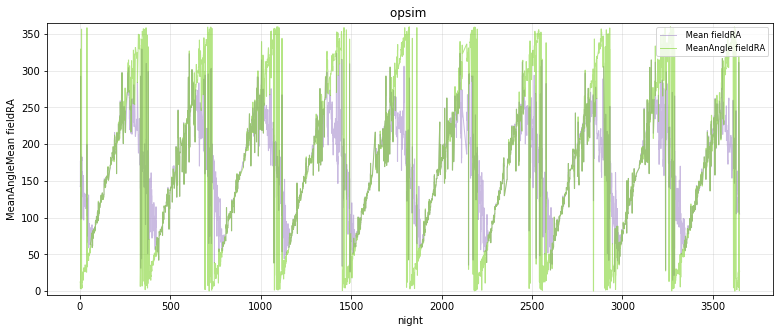

In [22]:
# Mean ra vs meanangle ra
ph = plots.PlotHandler()
ph.setMetricBundles([bdict['mean_ra'], bdict['meanangle_ra']])
plotDict = {'figsize': (13, 5), 'yMin': -5, 'yMax': 365}
ph.plot(plotFunc=plots.OneDBinnedData(), plotDicts=plotDict)

1

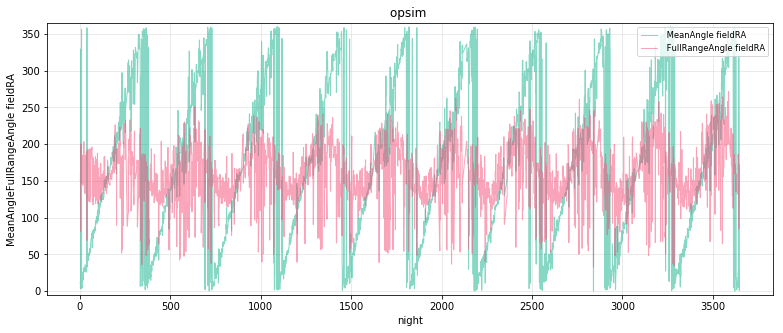

In [23]:
ph = plots.PlotHandler()
ph.setMetricBundles([bdict['meanangle_ra'], bdict['fullrangeangle_ra']])
plotDict = {'figsize': (13, 5), 'yMin': -5, 'yMax': 365}
ph.plot(plotFunc=plots.OneDBinnedData(), plotDicts=plotDict)

1

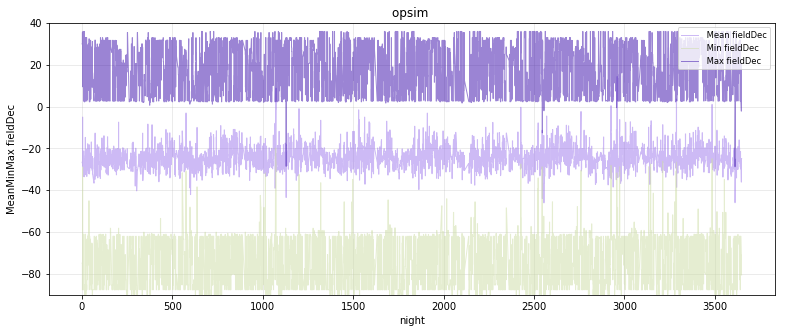

In [24]:
ph = plots.PlotHandler()
ph.setMetricBundles([bdict['mean_dec'], bdict['min_dec'], bdict['max_dec']])
plotDict = {'figsize': (13, 5), 'yMin': -90, 'yMax': 40}
ph.plot(plotFunc=plots.OneDBinnedData(), plotDicts=plotDict)